In [0]:
%matplotlib inline
from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
from torch import topk 
import numpy as np
import skimage.transform

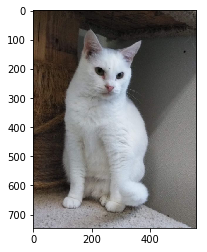

In [0]:
image=Image.open("/content/cat.jpeg")
imshow(image)

In [0]:
normalize=transforms.Normalize(mean=[.485,.456,.406],std=[.229,.224,.225])
preprocess=transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(),normalize])
display_transform=transforms.Compose([transforms.Resize((224,224))])

In [0]:
tensor=preprocess(image)

In [0]:
prediction_var=Variable((tensor.unsqueeze(0)).cuda(),requires_grad=True)


In [0]:
model=models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:01<00:00, 27146318.62it/s]


In [0]:
model.cuda()
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [0]:
class SaveFeatures():
  features=None
  def __init__(self,m):self.hook=m.register_forward_hook(self.hook_fn)
  def hook_fn(self,module,input,output): self.features=((output.cpu()).data).numpy()
  def remove(self): self.hook.remove()

In [0]:
final_layer=model._modules.get('fc')

In [0]:
activated_features=SaveFeatures(final_layer)

In [0]:
prediction=model(prediction_var)
pred_probabilities=F.softmax(prediction).data.squeeze()
activated_features.remove()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [0]:
pred_probabilities.shape

torch.Size([1000])

In [0]:
topk(pred_probabilities,1)

torch.return_types.topk(values=tensor([0.3387], device='cuda:0'), indices=tensor([285], device='cuda:0'))

In [0]:
def getCAM(feature_conv, weight_fc, class_idx):
  _,nc,h,w=feature_conv.shape
  cam=weight_fc[class_idx].dot(feature_conv.reshape((nc,h*w)))
  cam=cam.reshape(h,w)
  cam=cam-np.min(cam)
  cam_img=cam/np.max(cam)
  return [cam_img]

In [0]:
weight_softmax_params=list(model._modules.get('fc').parameters())
weight_softmax=np.squeeze(weight_softmax_params[0].cpu().data.numpy())


In [0]:
weight_softmax[class_idx.cpu()].shape

NameError: ignored

In [0]:
weight_softmax_params[0].shape

torch.Size([1000, 512])

In [0]:
class_idx=topk(pred_probabilities,1)[1].int()

In [0]:
#a,nc,h,w=activated_features.features.shape  
activated_features.features.shape

(1, 1000)

In [0]:
overlay=getCAM(activated_features.features, weight_softmax, class_idx)

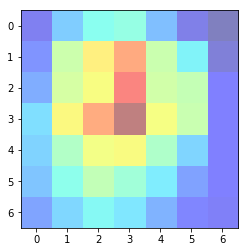

In [0]:
imshow(overlay[0], alpha=0.5, cmap='jet')

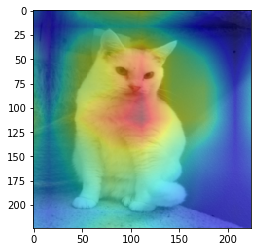

In [0]:
imshow(display_transform(image))
imshow(skimage.transform.resize(overlay[0], tensor.shape[1:3]),alpha=0.5, cmap='jet')

In [0]:
class_idx=topk(pred_probabilities,4)[1].int()

In [0]:
class_idx

tensor([285, 287, 281, 904], device='cuda:0', dtype=torch.int32)

In [0]:
overlay=getCAM(activated_features.features, weight_softmax,904)

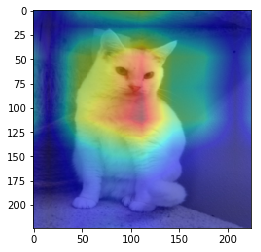

In [0]:
imshow(display_transform(image))
imshow(skimage.transform.resize(overlay[0],tensor.shape[1:3]),alpha=0.5,cmap='jet')